In [1]:
# IDEA: Add neck to the posture map?
from IPython import get_ipython

# %matplotlib qt
%load_ext autoreload
%autoreload 2

import time, os, sys, shutil
from utils.fitting_utils import *

# for math and plotting
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
#%matplotlib notebook
#%matplotlib widget
import scipy.stats as stats

from itertools import compress # for list selection with logical
from tqdm import tqdm

from multiprocessing import Process

# and pytorch
import torch

import sys, os, pickle
# import cv2
from colour import Color
import h5py
from tqdm import tqdm, tqdm_notebook
import glob
import itertools

In [2]:
# path to the neural data

ephys_folder = '/media/chrelli/SSD4TB/EPHYS_COPY/2020-11-10_10-19-39/'
# this is the female partner 
partner_sex = 'female'
tracking_folder = '/media/chrelli/SSD4TB/Data0_backup/recording_20201110-102009/'
rec_no = 0

# this is the male partner 
partner_sex = 'male'
tracking_folder = '/media/chrelli/SSD4TB/Data0_backup/recording_20201110-105540/'
rec_no = 3

In [3]:
# Now, load some neurons sorted with phy

spike_index_phy = np.load(ephys_folder+
    "experiment1/recording1/continuous/Rhythm_FPGA-100.0/continuous/continuous-merged.GUI/"+
    "spike_times.npy")

spike_ids_phy = np.arange(len(spike_index_phy))

clusters_phy = np.load(ephys_folder+
    "experiment1/recording1/continuous/Rhythm_FPGA-100.0/continuous/continuous-merged.GUI/"+
    "spike_clusters.npy")

templates = np.load(ephys_folder+
    "experiment1/recording1/continuous/Rhythm_FPGA-100.0/continuous/continuous-merged.GUI/"+
    "templates.npy")

cluster_info = pd.read_csv(ephys_folder+
    "experiment1/recording1/continuous/Rhythm_FPGA-100.0/continuous/continuous-merged.GUI/"+
    "cluster_info.tsv", sep='\t') 

phy_params_path = ephys_folder+"experiment1/recording1/continuous/Rhythm_FPGA-100.0/continuous/continuous-merged.GUI/"+                    "params.py"

# also parse the recording start synch time!!!

with open (ephys_folder+
    "experiment1/recording1/sync_messages.txt", "r") as myfile:
    sync_messages=myfile.readlines()


sample_rate = 30000.

# filter only good cells
cluster_info = cluster_info[cluster_info.group == 'good'] #.sort_values(by = 'amp')
cluster_info.head()
n_neurons = cluster_info.shape[0]

In [4]:
# extract the recording start from the sync_messages by a regular expr
import re
rec_start_sample= int(re.findall(r'[0-9]+@',sync_messages[1])[0][:-1])
print("recording started at sample # {}".format(rec_start_sample))
ephys_rec_start_sample = rec_start_sample
ephys_rec_start_time = rec_start_sample/sample_rate

recording started at sample # 4325632


In [5]:
# load the female and male timing and behavior!
timing_male = pickle.load( open( ephys_folder+'timing_male.pkl', "rb" ) )
tracked_behavior_male = pickle.load( open( ephys_folder+'tracked_behavior_male.pkl', "rb" ) )

timing_female = pickle.load( open( ephys_folder+'timing_female.pkl', "rb" ) )
tracked_behavior_female = pickle.load( open( ephys_folder+'tracked_behavior_female.pkl', "rb" ) )

In [6]:
# stack together the detected social events!

event_start_master = []
event_duration_master = []
event_partner_sex_master = []
event_type_master = []

# do the female
for i,tt in enumerate(['n2n','n0t1','n1t0']):
    event_start_master.append(timing_female['event_times_ephys'][i])
    # TODO for this rough look, we ignore the possibility of dropped frames
    fps = 60
    event_duration_master.append(timing_female['event_duration'][i] * 1/fps)
    n_events = len(timing_female['event_times_ephys'][i])   
    event_type_master.append([tt]*n_events)
    event_partner_sex_master.append(['f']*n_events)
# do the male
for i,tt in enumerate(['n2n','n0t1','n1t0']):
    event_start_master.append(timing_male['event_times_ephys'][i])
    # TODO for this rough look, we ignore the possibility of dropped frames
    fps = 60
    event_duration_master.append(timing_male['event_duration'][i] * 1/fps)
    n_events = len(timing_male['event_times_ephys'][i])   
    event_type_master.append([tt]*n_events)
    event_partner_sex_master.append(['m']*n_events)

event_start_master = np.concatenate(event_start_master)
event_duration_master = np.concatenate(event_duration_master)
event_partner_sex_master = np.concatenate(event_partner_sex_master)
event_type_master = np.concatenate(event_type_master)

In [7]:
# stack together the social distances, body-points and fwd/left speeds!

# TODO in this case, the female was first, add sorting step!
# time stamps, where we have tracked the behavior

behavior_stamps = np.hstack([ ti['reference_stamps_ephys_time'][tr['start_frame']:tr['end_frame'] ]  for ti,tr in zip([timing_female,timing_male],[tracked_behavior_female,tracked_behavior_male] ) ])
behavior_stamps = behavior_stamps*1e-3
d_n2n = np.hstack([ tb['d_nose2nose'] for tb in [tracked_behavior_female,tracked_behavior_male] ])
d_n0t1 = np.hstack([ tb['d_nose02ass'] for tb in [tracked_behavior_female,tracked_behavior_male] ])
d_n1t0 = np.hstack([ tb['d_nose12ass'] for tb in [tracked_behavior_female,tracked_behavior_male] ])

fwd_0 = np.hstack([ tb['fwd'][0] for tb in [tracked_behavior_female,tracked_behavior_male] ])
fwd_1 = np.hstack([ tb['fwd'][1] for tb in [tracked_behavior_female,tracked_behavior_male] ])

left_0 = np.hstack([ tb['left'][0] for tb in [tracked_behavior_female,tracked_behavior_male] ])
left_1 = np.hstack([ tb['left'][1] for tb in [tracked_behavior_female,tracked_behavior_male] ])

up_0 = np.hstack([ tb['up'][0] for tb in [tracked_behavior_female,tracked_behavior_male] ])
up_1 = np.hstack([ tb['up'][1] for tb in [tracked_behavior_female,tracked_behavior_male] ])

c_ears_1 = np.concatenate([ tb['c_ears_1'] for tb in [tracked_behavior_female,tracked_behavior_male] ],axis=0)


speed_0 = np.sqrt(fwd_0**2+left_0**2)
speed_1 = np.sqrt(fwd_1**2+left_1**2)

speed3D_0 = np.sqrt(fwd_0**2+left_0**2+up_0**2)
speed3D_1 = np.sqrt(fwd_1**2+left_1**2+up_1**2)



In [8]:
tracking_holder = np.hstack([ tb['tracking_holder'] for tb in [tracked_behavior_female,tracked_behavior_male] ])
ivar = tracked_behavior_female['ivar']

def wrap(phases):
    phases = (phases + np.pi) % (2 * np.pi) - np.pi
    return phases

b0 = tracking_holder[0,:]
c0 = tracking_holder[1,:]
s0 = tracking_holder[2,:]
psi0 = tracking_holder[3,:]
theta0 = tracking_holder[4,:]
phi0 = tracking_holder[5,:]
x0 = tracking_holder[6,:]
y0 = tracking_holder[7,:]
z0 = tracking_holder[8,:]
b1 = tracking_holder[9,:]
c1 = tracking_holder[10,:]
s1 = tracking_holder[11,:]
theta1 = tracking_holder[12,:]
phi1 = tracking_holder[13,:]
x1 = tracking_holder[14,:]
y1 = tracking_holder[15,:]
z1 = tracking_holder[16,:]
frame = tracking_holder[17,:]



In [9]:
# get the head angles and the body coordinates

bp_list_0 = [ tb['body_points'][0] for tb in [tracked_behavior_female,tracked_behavior_male] ]
bp_0 = [np.concatenate([bp_list_0[0][i],bp_list_0[1][i]],axis = 0) for i in range(6)]

bp_list_1 = [ tb['body_points'][1] for tb in [tracked_behavior_female,tracked_behavior_male] ]
bp_1 = [np.concatenate([bp_list_1[0][i],bp_list_1[1][i]],axis = 0) for i in range(6)]

body_points = [bp_0,bp_1]

type_list = np.array(['hip','tail','mid','nose','tip','impl'])
c_hip_0 = body_points[0][0]
c_hip_1 = body_points[1][0]
c_tail_0 = body_points[0][1]
c_tail_1 = body_points[1][1]
c_mid_0 = body_points[0][2]
c_mid_1 = body_points[1][2]
c_nose_0 = body_points[0][3]
c_nose_1 = body_points[1][3]
c_tip_0 = body_points[0][4]
c_tip_1 = body_points[1][4]
c_impl_0 = body_points[0][5]
c_impl_1 = body_points[1][5]

# for the 2D head direction
# just get the 2D coordinates!
v_hd_0 = c_tip_0-c_nose_0
a_nose_hd_0 = np.arctan2(v_hd_0[:,1],v_hd_0[:,0])
v_hd_1 = c_tip_1-c_nose_1
a_nose_hd_1 = np.arctan2(v_hd_1[:,1],v_hd_1[:,0])

# also get HD angles for the hip direction
v_hip_0 = c_hip_0-c_tail_0
a_hip_hd_0 = np.arctan2(v_hip_0[:,1],v_hip_0[:,0])
v_hip_1 = c_hip_1-c_tail_1
a_hip_hd_1 = np.arctan2(v_hip_1[:,1],v_hip_1[:,0])

# body elevation angle, from the z component of v_hip
v_hip_0_xy = np.sqrt(np.sum(v_hip_0[:,:2]**2,axis = 1))
a_hip_elevation_0 = np.arctan(v_hip_0[:,2]/v_hip_0_xy)
v_hip_1_xy = np.sqrt(np.sum(v_hip_1[:,:2]**2,axis = 1))
a_hip_elevation_1 = np.arctan(v_hip_1[:,2]/v_hip_1_xy)


# head elevation angle, from the nose vector
v_nose_0 = c_tip_0-c_nose_0
v_nose_1 = c_tip_1-c_nose_1

v_nose_0_xy = np.sqrt(np.sum(v_nose_0[:,:2]**2,axis = 1))
a_nose_elevation_0 = np.arctan(v_nose_0[:,2]/v_nose_0_xy)

v_nose_1_xy = np.sqrt(np.sum(v_nose_1[:,:2]**2,axis = 1))
a_nose_elevation_1 = np.arctan(v_nose_1[:,2]/v_nose_1_xy)

# also get the UD angle of the head

a_nose_ud_1 = a_nose_elevation_0-a_hip_elevation_0
a_nose_ud_0 = a_nose_elevation_1-a_hip_elevation_1



In [10]:
from utils.fitting_utils import angle_between

a_nose_lr_0 = []
for i in tqdm( range(v_nose_0.shape[0]) ):
    v1= v_nose_0[i,:] * np.array([1,1,0])
    v2= v_hip_0[i,:] * np.array([1,1,0])
    a_nose_lr_0.append(angle_between(v1,v2))
a_nose_lr_0 = np.array(a_nose_lr_0)


a_nose_lr_1 = []
for i in tqdm( range(v_nose_1.shape[0]) ):
    v1= v_nose_1[i,:] * np.array([1,1,0])
    v2= v_hip_1[i,:] * np.array([1,1,0])
    a_nose_lr_1.append(angle_between(v1,v2))
a_nose_lr_1 = np.array(a_nose_lr_1)


100%|██████████| 129558/129558 [00:05<00:00, 21998.48it/s]


In [11]:
# gazing nose or gazing tail
v_gaze_nose = c_tip_1-c_nose_0
v_gaze_tail = c_tail_1-c_nose_0
v_gaze_mid = c_mid_1-c_nose_0

# a_gaze_nose = []
# for i in tqdm( range(v_nose_1.shape[0]) ):
#     v2= v_gaze_nose[i,:] * np.array([1,1,0])
#     v1= v_nose_0[i,:] * np.array([1,1,0])
#     a_gaze_nose.append(angle_between(v1,v2))
# a_gaze_nose = np.array(a_gaze_nose)

# a_gaze_tail = []
# for i in tqdm( range(v_nose_1.shape[0]) ):
#     v2= v_gaze_tail[i,:] * np.array([1,1,0])
#     v1= v_nose_0[i,:] * np.array([1,1,0])
#     a_gaze_tail.append(angle_between(v1,v2))
# a_gaze_tail = np.array(a_gaze_tail)


# the nose of the implanted guy is the reference! so that's v1
a_gaze_mid= []
for i in tqdm( range(v_nose_1.shape[0]) ):
    v2= v_gaze_mid[i,:] * np.array([1,1,0])
    v1= v_nose_0[i,:] * np.array([1,1,0])
    a_gaze_mid.append(angle_between(v1,v2))
a_gaze_mid = np.array(a_gaze_mid)




100%|██████████| 129558/129558 [00:06<00:00, 21066.80it/s]


In [12]:
# calculate the head roll using the trick from the ear calculation in the wrangler!
               
def rotate_f_onto_t(f,t):
    # make unit vectors
    f = f/np.linalg.norm(f)
    t = t/np.linalg.norm(t)

    # trick from here: https://math.stackexchange.com/questions/180418/calculate-rotation-matrix-to-align-vector-a-to-vector-b-in-3d
    # from this paper: http://cs.brown.edu/research/pubs/pdfs/1999/Moller-1999-EBA.pdf
    # to rotate vector f onto vector t (around f x t!), we can do:
    v = np.cross(f, t)
    u = v/np.linalg.norm(v)
    c = np.dot(f, t)
    h = (1 - c)/(1 - c**2)

    vx, vy, vz = v
    rot = np.array([[c + h*vx**2, h*vx*vy - vz, h*vx*vz + vy],
          [h*vx*vy+vz, c+h*vy**2, h*vy*vz-vx],
          [h*vx*vz - vy, h*vy*vz + vx, c+h*vz**2]])
    return rot

v_impl = c_impl_0 - c_nose_0
v_impl_rotated = np.zeros_like(v_impl)

for i in tqdm( range(v_impl.shape[0]) ):
    # first calculatet the the projection onto a plane which has the nose vector as the normal
    plane_point = c_nose_0[i]
    plane_normal = v_nose_0[i]
    v_up = np.array([0,0,1]) # pointing to z
    # idea is to decompose the 3D rotation into two steps, since 3D rotation has many solutions
    # first, find a vector, which would rotate the nose direction vector 
    # into the xy plane. 
    rotA = rotate_f_onto_t(plane_normal,plane_normal*np.array([1,1,0]))
    # and then, we rotate in the xy plane to point in x-direction
    rotB = rotate_f_onto_t(plane_normal*np.array([1,1,0]),np.array([1,0,0]))
    # Now, we also rotate the implant vector by the same matrix 
    rot = rotB @ rotA 
    
    v_impl_rotated[i] = rot @ v_impl[i]
    
# now we can just get the angle from the y and z coordinate
head_roll_0 = wrap( np.arctan2(v_impl_rotated[:,2],v_impl_rotated[:,1]) - np.pi/2 )
# subtracted pi/2, so 0 is pointing up

100%|██████████| 129558/129558 [00:17<00:00, 7603.64it/s]


In [13]:
# now, do the same, but for the center of the ears, estimated for the other guy

v_ear = c_ears_1 - c_nose_1
v_ear_rotated = np.zeros_like(v_ear)

for i in tqdm( range(v_ear.shape[0]) ):
    # first calculatet the the projection onto a plane which has the nose vector as the normal
    plane_point = c_nose_1[i]
    plane_normal = v_nose_1[i]
    v_up = np.array([0,0,1]) # pointing to z
    # idea is to decompose the 3D rotation into two steps, since 3D rotation has many solutions
    # first, find a vector, which would rotate the nose direction vector 
    # into the xy plane. 
    rotA = rotate_f_onto_t(plane_normal,plane_normal*np.array([1,1,0]))
    # and then, we rotate in the xy plane to point in x-direction
    rotB = rotate_f_onto_t(plane_normal*np.array([1,1,0]),np.array([1,0,0]))
    # Now, we also rotate the implant vector by the same matrix 
    rot = rotB @ rotA 
    
    v_ear_rotated[i] = rot @ v_ear[i]
    
# now we can just get the angle from the y and z coordinate
head_roll_1 = wrap( np.arctan2(v_ear_rotated[:,2],v_ear_rotated[:,1]) - np.pi/2 )
# subtracted pi/2, so 0 is pointing up

100%|██████████| 129558/129558 [00:16<00:00, 7736.37it/s]


In [15]:
from utils.analysis_tools import easy_kernel

head_roll_0 = np.convolve(head_roll_0,easy_kernel(10),'same')
head_roll_1 = np.convolve(head_roll_1,easy_kernel(10),'same')



/home/chrelli/git/3ddd_mouse_tracker/analysis/utils/analysis_tools.py:74: MatplotlibDeprecationWarning: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  matplotlib.rcParams['mathtext.fallback_to_cm'] = False
/home/chrelli/git/3ddd_mouse_tracker/analysis/utils/analysis_tools.py:74: MatplotlibDeprecationWarning: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
  matplotlib.rcParams['mathtext.fallback_to_cm'] = False
/home/chrelli/git/3ddd_mouse_tracker/analysis/utils/analysis_tools.py:74: MatplotlibDeprecationWarning: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  matplotlib.rcParams['mathtext.fallback_to_cm'] = False


In [16]:

## Save all the binned spikes for later!
# let's get a quick and dirty firing rate by binning
i_neuron = 1
for i_neuron in range(n_neurons):
    # i_neuron = 0

    cluster_id = cluster_info.id.values[i_neuron]
    spike_times = spike_index_phy[clusters_phy == cluster_id]/sample_rate + ephys_rec_start_time

    # we do a little trick here, due to how np.hist handles edges
    bin_edges = np.hstack([behavior_stamps,behavior_stamps[-1]+np.median(np.diff(behavior_stamps))])
    binned_spikes,_ = np.histogram(spike_times,bins = bin_edges)

    # there will be a gigantic count in the break in the recording, which we will simply kill off!
    # TODO handle this better, goog enough for now
    binned_spikes[np.diff(bin_edges)> 10*np.median(np.diff(bin_edges))] = 0
    # convert from spike count to rate!
    binned_rate = binned_spikes/np.median(np.diff(behavior_stamps))
    np.save('model_masters/binned_spikes_i_neuron_{}.npy'.format(i_neuron),binned_spikes)
    

In [17]:
# let's get a quick and dirty firing rate by binning
i_neuron = 1

# i_neuron = 0

cluster_id = cluster_info.id.values[i_neuron]
spike_times = spike_index_phy[clusters_phy == cluster_id]/sample_rate + ephys_rec_start_time

# we do a little trick here, due to how np.hist handles edges
bin_edges = np.hstack([behavior_stamps,behavior_stamps[-1]+np.median(np.diff(behavior_stamps))])
binned_spikes,_ = np.histogram(spike_times,bins = bin_edges)

# there will be a gigantic count in the break in the recording, which we will simply kill off!
# TODO handle this better, goog enough for now
binned_spikes[np.diff(bin_edges)> 10*np.median(np.diff(bin_edges))] = 0
# convert from spike count to rate!
binned_rate = binned_spikes/np.median(np.diff(behavior_stamps))

from utils.analysis_tools import easy_kernel
# smooth again
kernel_length = 10
# kernel = np.ones(kernel_length )/kernel_length 
kernel = easy_kernel(kernel_length)
# kernel = 1.

smooth_rate = np.convolve(binned_rate,kernel,'same') 


Text(0, 0.5, 'Firing rate [Hz]')

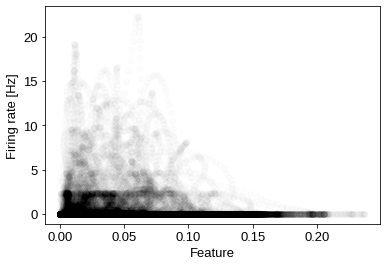

In [18]:
behavior_feature = d_n2n
# behavior_feature = d_n0t1
# behavior_feature = d_n1t0

# behavior_feature = fwd_0
# behavior_feature = left_0

behavior_feature = speed_0

# 
plt.figure()
ax = plt.gca()
ax.plot(behavior_feature,smooth_rate,'ok',alpha = 0.01)
ax.set_xlabel('Feature')
ax.set_ylabel('Firing rate [Hz]')

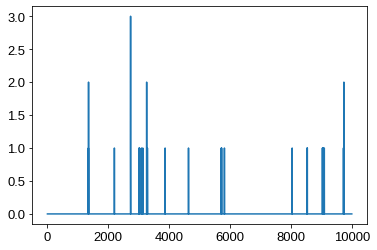

In [19]:
plt.figure()
plt.plot(binned_spikes[:10000])

In [20]:
# save to a plotting script!
# to fit data, the algo needs an A-matrix [the binned predictor]
# the xbins (ybins), dx (dy)

behavior_feature = d_n2n
xbins = np.hstack([np.arange(0,5,1),np.arange(5,15,2),np.arange(15,33,3)])
# these are the bin CENTERS! in SI units METERS!
xbins = np.arange(0,.3,.02)+.01

def bin_1d_predictor(behavior_feature,xbins):   
    # calculate the difference between the feature and the bin-edge
    bin_dist = np.abs(behavior_feature[:,np.newaxis] - xbins)
    # find the min distance to get the index
    bin_index = np.argmin(bin_dist,axis = 1)
    # make a predictor matrix!
    n_time, n_params = len(behavior_feature), len(xbins)
    A = np.zeros([n_time,n_params],dtype = 'bool')
    # TODO this is maybe not the most efficient way to do this..
    A[np.arange(n_time),bin_index] = True
    return A

A = bin_1d_predictor(behavior_feature,xbins)

# stack the predictors together! Tell the algo what type they are!
predictor_stack = []

# #######################
# SOCIAL PREDICTORS
# #######################

# this is a good binning for the distances, #TODO maybe log-space it?
xbins = np.arange(0,.3,.02)+.01
predictor_stack.append({"name":"d_n2n","data": d_n2n, "xbins": xbins,'type': '1d','unit': 'm'})
predictor_stack.append({"name":"d_n0t1","data": d_n0t1, "xbins": xbins,'type': '1d','unit': 'm'})
predictor_stack.append({"name":"d_n1t0","data": d_n1t0, "xbins": xbins,'type': '1d','unit': 'm'})

def social_speed(aa):
    daa = np.hstack([0,np.diff(aa)])
    kernel = easy_kernel(10)
    return np.convolve(daa,kernel,'same')

xbins = np.linspace(-.002,.002,15)
# predictor_stack.append({"name":"diff_n2n","data": social_speed(d_n2n), "xbins": xbins,'type': '1d','unit': 'm/s'})
# predictor_stack.append({"name":"diff_n0t1","data": social_speed(d_n0t1), "xbins": xbins,'type': '1d','unit': 'm/s'})
# predictor_stack.append({"name":"diff_n1t0","data": social_speed(d_n1t0), "xbins": xbins,'type': '1d','unit': 'm/s'})

# social distance change
d_social = np.linalg.norm(c_mid_1-c_mid_0,axis=1)
xbins = np.linspace(-.002,.002,15)
predictor_stack.append({"name":"diffd_social","data": social_speed(d_social), "xbins": xbins,'type': '1d','unit': 'm'})


# social gaze direction
xbins = np.linspace(-np.pi,np.pi,16)[:-1] # This one is circular!
# predictor_stack.append({"name":"a_gaze_nose","data": a_gaze_nose, "xbins": xbins,'type': '1d_circ','unit': 'rad'})
# predictor_stack.append({"name":"a_gaze_tail","data": a_gaze_tail, "xbins": xbins,'type': '1d_circ','unit': 'rad'})
predictor_stack.append({"name":"a_gaze_mid","data": a_gaze_mid, "xbins": xbins,'type': '1d_circ','unit': 'rad'})


# #######################
# MOVEMENT PREDICTORS
# #######################

# the componenets of the speed (in a body-centered frame of ref)
xbins = np.linspace(-.05,.20,15)
predictor_stack.append({"name":"fwd_0","data": fwd_0, "xbins": xbins,'type': '1d','unit': 'm/s'})
predictor_stack.append({"name":"fwd_1","data": fwd_1, "xbins": xbins,'type': '1d','unit': 'm/s'})
xbins = np.linspace(-.05,.05,11) # maybe just 10?
predictor_stack.append({"name":"left_0","data": left_0, "xbins": xbins,'type': '1d','unit': 'm/s'})
predictor_stack.append({"name":"left_1","data": left_1, "xbins": xbins,'type': '1d','unit': 'm/s'})
xbins = np.arange(-.04,.05,0.01) # maybe just 10?
predictor_stack.append({"name":"up_0","data": up_0, "xbins": xbins,'type': '1d','unit': 'm/s'})
predictor_stack.append({"name":"up_1","data": up_1, "xbins": xbins,'type': '1d','unit': 'm/s'})

# The absolute value of the speed
xbins = np.linspace(0,.19,15)+.01
predictor_stack.append({"name":"speed3D_0","data": speed3D_0, "xbins": xbins,'type': '1d','unit': 'm/s'})
predictor_stack.append({"name":"speed3D_1","data": speed3D_1, "xbins": xbins,'type': '1d','unit': 'm/s'})


def angle_speed(aa):
    daa = np.hstack([0,wrap(np.diff(aa))])
    kernel = easy_kernel(10)
    return np.convolve(daa,kernel,'same')


# #######################
# POSTURE PREDICTORS
# #######################

# hip posture
xbins = np.linspace(0,np.pi/2,15) # Not a circular angle
predictor_stack.append({"name":"a_hip_elevation_0","data": a_hip_elevation_0, "xbins": xbins,'type': '1d','unit': 'rad'})
predictor_stack.append({"name":"a_hip_elevation_1","data": a_hip_elevation_1, "xbins": xbins,'type': '1d','unit': 'rad'})
# hip movement
xbins = np.linspace(-.03,.03,15) # Not a circular angle
predictor_stack.append({"name":"diffa_hip_elevation_0","data": angle_speed(a_hip_elevation_0), "xbins": xbins,'type': '1d','unit': 'rad/s'})
predictor_stack.append({"name":"diffa_hip_elevation_1","data": angle_speed(a_hip_elevation_1), "xbins": xbins,'type': '1d','unit': 'rad/s'})

# and nose posture
xbins = np.linspace(0,np.pi/2,15) # Not a circular angle
predictor_stack.append({"name":"a_nose_elevation_0","data": a_nose_elevation_0, "xbins": xbins,'type': '1d','unit': 'rad'})
predictor_stack.append({"name":"a_nose_elevation_1","data": a_nose_elevation_1, "xbins": xbins,'type': '1d','unit': 'rad'})
xbins = np.linspace(-.04,.04,15)
predictor_stack.append({"name":"diffa_nose_elevation_0","data": angle_speed(a_nose_elevation_0), "xbins": xbins,'type': '1d','unit': 'rad/s'})
predictor_stack.append({"name":"diffa_nose_elevation_1","data": angle_speed(a_nose_elevation_1), "xbins": xbins,'type': '1d','unit': 'rad/s'})


# head posture left-right and up/down
xbins = np.linspace(-np.pi/3,np.pi/3,15)
predictor_stack.append({"name":"a_nose_lr_0","data": a_nose_lr_0, "xbins": xbins,'type': '1d','unit': 'rad'})
predictor_stack.append({"name":"a_nose_lr_1","data": a_nose_lr_1, "xbins": xbins,'type': '1d','unit': 'rad'})
xbins = np.linspace(-.9,.9,15) # todo make straight pi/3
predictor_stack.append({"name":"a_nose_ud_0","data": a_nose_ud_0, "xbins": xbins,'type': '1d','unit': 'rad'})
predictor_stack.append({"name":"a_nose_ud_1","data": a_nose_ud_1, "xbins": xbins,'type': '1d','unit': 'rad'})

# head movement left-right and up/down
xbins = np.linspace(-.04,.04,15)
predictor_stack.append({"name":"diffa_nose_lr_0","data": angle_speed(a_nose_lr_0), "xbins": xbins,'type': '1d','unit': 'rad/s'})
predictor_stack.append({"name":"diffa_nose_lr_1","data": angle_speed(a_nose_lr_1), "xbins": xbins,'type': '1d','unit': 'rad/s'})
xbins = np.linspace(-.04,.04,15)
predictor_stack.append({"name":"diffa_nose_ud_0","data": angle_speed(a_nose_ud_0), "xbins": xbins,'type': '1d','unit': 'rad/s'})
predictor_stack.append({"name":"diffa_nose_ud_1","data": angle_speed(a_nose_ud_1), "xbins": xbins,'type': '1d','unit': 'rad/s'})

# Spine stretch
xbins = np.linspace(.5,1.,15)
predictor_stack.append({"name":"s0","data": s0, "xbins": xbins,'type': '1d','unit': 'a.u.'})
predictor_stack.append({"name":"s1","data": s1, "xbins": xbins,'type': '1d','unit': 'a.u.'})
# Spine stretch speed
xbins = np.linspace(-.01,.01,15)
predictor_stack.append({"name":"diffs0","data": social_speed(s0), "xbins": xbins,'type': '1d','unit': 'a.u./s'})
predictor_stack.append({"name":"diffs1","data": social_speed(s1), "xbins": xbins,'type': '1d','unit': 'a.u./s'})

# head posture ROLL!! TODO!
xbins = np.linspace(-np.pi*2/3,np.pi*2/3,15)
predictor_stack.append({"name":"head_roll_0","data": head_roll_0, "xbins": xbins,'type': '1d','unit': 'rad'})
predictor_stack.append({"name":"head_roll_1","data": head_roll_1, "xbins": xbins,'type': '1d','unit': 'rad'})
xbins = np.linspace(-.04,.04,15)
predictor_stack.append({"name":"diffhead_roll_0","data": angle_speed(head_roll_0), "xbins": xbins,'type': '1d','unit': 'rad/s'})
predictor_stack.append({"name":"diffhead_roll_1","data": angle_speed(head_roll_1), "xbins": xbins,'type': '1d','unit': 'rad/s'})



# #######################
# SPATIAL PREDICTORS
# #######################

# spatial 2D space
xbins = np.linspace(-.13,.13,15) 
predictor_stack.append({"name":"x_hip_0","data": c_hip_0[:,0], "xbins": xbins,'type': '1d','unit': 'm'})
predictor_stack.append({"name":"x_hip_1","data": c_hip_1[:,0], "xbins": xbins,'type': '1d','unit': 'm'})
predictor_stack.append({"name":"y_hip_0","data": c_hip_0[:,1], "xbins": xbins,'type': '1d','unit': 'm'})
predictor_stack.append({"name":"y_hip_1","data": c_hip_1[:,1], "xbins": xbins,'type': '1d','unit': 'm'})
xbins = np.linspace(0.02,0.05,15) 
predictor_stack.append({"name":"z_hip_0","data": c_hip_0[:,2], "xbins": xbins,'type': '1d','unit': 'm'})
predictor_stack.append({"name":"z_hip_1","data": c_hip_0[:,2], "xbins": xbins,'type': '1d','unit': 'm'})

# spatial distance to center of arena
xbins = np.linspace(0,.14,15) 
predictor_stack.append({"name":"d_arena_0","data": np.sqrt(np.sum(c_hip_0[:,:2]**2,axis=1)), "xbins": xbins,'type': '1d','unit': 'm'})
predictor_stack.append({"name":"d_arena_1","data": np.sqrt(np.sum(c_hip_1[:,:2]**2,axis=1)), "xbins": xbins,'type': '1d','unit': 'm'})

# spatial, 2D head direction
xbins = np.linspace(-np.pi,np.pi,16)[:-1] # This one is circular!
predictor_stack.append({"name":"a_nose_hd_0","data": a_nose_hd_0, "xbins": xbins,'type': '1d_circ','unit': 'rad'})
predictor_stack.append({"name":"a_nose_hd_1","data": a_nose_hd_1, "xbins": xbins,'type': '1d_circ','unit': 'rad'})

# spatial, 2D body direction
predictor_stack.append({"name":"a_hip_hd_0","data": a_hip_hd_0, "xbins": xbins,'type': '1d_circ','unit': 'rad'})
predictor_stack.append({"name":"a_hip_hd_1","data": a_hip_hd_1, "xbins": xbins,'type': '1d_circ','unit': 'rad'})

# spatial 2D hip rotation speed
xbins = np.linspace(-0.15,0.15,15) # This one is circular!
predictor_stack.append({"name":"diffa_hip_hd_0","data": angle_speed(np.unwrap(a_hip_hd_0)), "xbins": xbins,'type': '1d','unit': 'rad'})
predictor_stack.append({"name":"diffa_hip_hd_1","data": angle_speed(np.unwrap(a_hip_hd_1)), "xbins": xbins,'type': '1d','unit': 'rad'})

# spatial 2D gaze rotation speed



# generate the binning!
for p in predictor_stack:
    if (p['type'] == '1d') or (p['type'] == '1d_circ'):
        p['A'] = bin_1d_predictor(p['data'],p['xbins'])
        p['nxbins'] = len(p['xbins'])
        p['nsub'] = p['A'].shape[1]


In [21]:
# make the folds, skipping across the data
n_folds = 10
n_skips = 3
n_chunks = n_folds*n_skips
n_time = predictor_stack[0]['data'].shape[0]
chunk_size = int(n_time/n_chunks)
time_index = np.arange(n_time)
fold_index = np.floor(np.linspace(0,n_folds*n_skips,n_time))


In [31]:
# sort the predictors!


p_social = {'key':['d_n2n','d_n0t1','d_n1t0','diffd_social','a_gaze_mid'],
           'lab':['nose<->nose','nose0->tail1','nose1->tail0','d/dt[d_social]','orientation']
           }
            
p_posture_0 = {'key':['a_nose_lr_0','a_nose_ud_0','head_roll_0','a_hip_elevation_0','s0'],
           'lab':['head yaw','head pitch', 'head roll','hip pitch','spine']
           }

p_space_0 = {'key':['x_hip_0','y_hip_0','z_hip_0','d_arena_0','a_nose_hd_0'],
           'lab':['x','y','z','d_center','head dir.']
           }

p_movement_0 = {'key':['fwd_0','left_0','up_0','speed3D_0',
                       'diffa_nose_lr_0','diffa_nose_ud_0','diffhead_roll_0',
                       'diffa_hip_hd_0','diffa_hip_elevation_0','diffs0'
                      ],
           'lab':['v_fwd','v_left','v_up','|v|',
                  'd/dt[head y.]','d/dt[head p.]', 'd/dt[head r.]',
                  'd/dt[hip y.]','d/dt[hip p.]','d/dt[spine]']
           }


p_posture_1 = {'key':['a_nose_lr_1','a_nose_ud_1','head_roll_1','a_hip_elevation_1','s1'],
           'lab':['head yaw','head pitch', 'head roll','hip pitch','spine']
           }

p_space_1 = {'key':['x_hip_1','y_hip_1','z_hip_1','d_arena_1','a_nose_hd_1'],
           'lab':['x','y','z','d_center','head dir.']
           }

p_movement_1 = {'key':['fwd_1','left_1','up_1','speed3D_1',
                       'diffa_nose_lr_1','diffa_nose_ud_1','diffhead_roll_1',
                       'diffa_hip_hd_1','diffa_hip_elevation_1','diffs1'
                      ],
           'lab':['v_fwd','v_left','v_up','|v|',
                  'd/dt[head y.]','d/dt[head p.]', 'd/dt[head r.]',
                  'd/dt[hip y.]','d/dt[hip p.]','d/dt[spine]']
           }

ps_list = [p_social,p_posture_0,p_space_0,p_movement_0,p_posture_1,p_space_1,p_movement_1]

all_keys = np.hstack([ps['key'] for ps in ps_list])
all_labs = np.hstack([ps['lab'] for ps in ps_list]) 

names_in_stack = [p['name'] for p in predictor_stack]

ps_index = [np.where(np.isin(names_in_stack,key))[0][0] for key in all_keys]

predictor_stack = [predictor_stack[i] for i in ps_index]
for p,lab in zip(predictor_stack,all_labs):
    p['lab'] = lab
    
import pickle    
pickle.dump(predictor_stack, open('model_masters/predictor_stack.p', "wb"))  # save it into a file named save.p
    

In [32]:
#predictor_stack = [predictor_stack[0], predictor_stack[1], predictor_stack[2]]

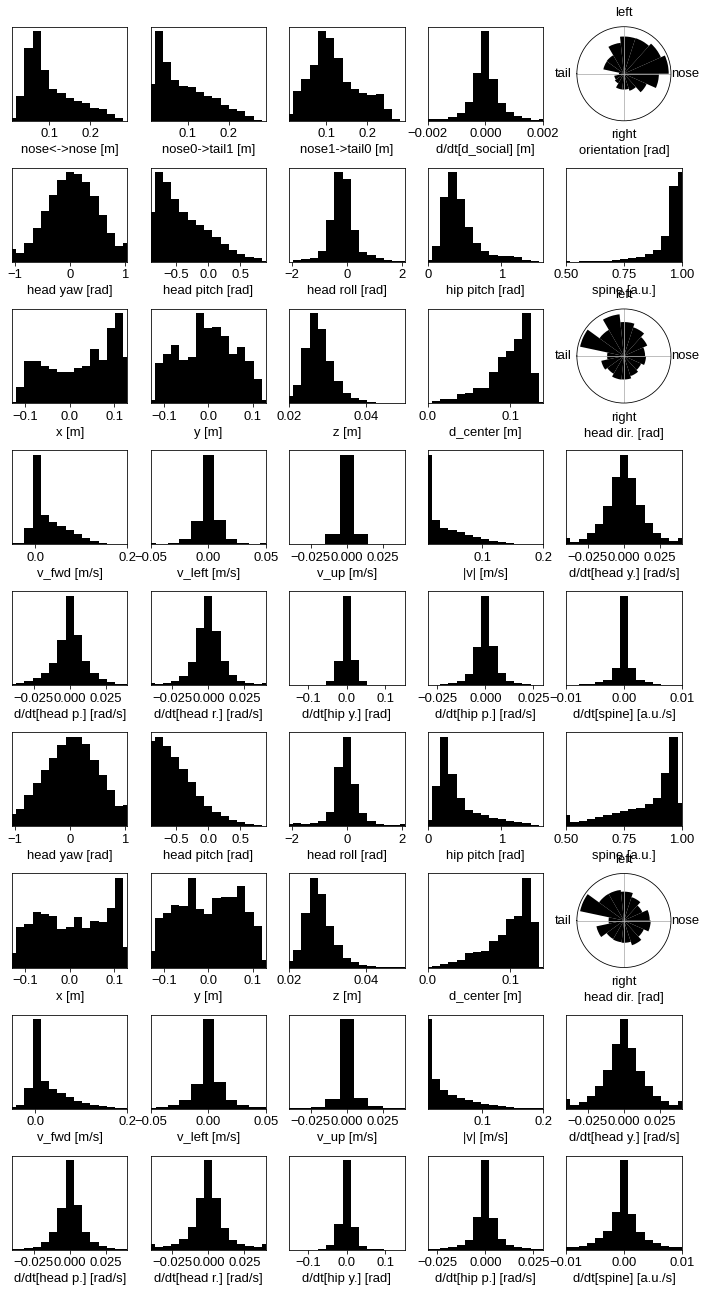

In [33]:
# plot ALL the predictors, that have been included for fitting!

n_p = len(predictor_stack)
sz = 6
plt.figure(figsize = (3*4,2.5*9))
for i_p,p in enumerate(predictor_stack):
    
#     i_sub = np.hstack([np.arange(1,6),np.arange(11,99)])[i_p]
    
    i_sub = 1+i_p
    
    xbins = p['xbins']
    # make firing rate!
    A = p['A']
    A_spikes = np.sum(A,axis =0)
    
    if p['type'] == '1d':
        ax = plt.subplot(9,5,i_sub)
        ax.bar(xbins,A_spikes,facecolor = 'k',width = np.median(np.diff(xbins)))
        ax.set_xlim(xbins[[0,-1]])
        ax.set_xlabel("{} [{}]".format(p['lab'],p['unit']))
    if p['type'] == '1d_circ':
        ax = plt.subplot(9,5,i_sub,projection='polar')
        ax.bar(xbins,A_spikes,facecolor = 'k',width = np.median(np.diff(xbins)))
        ax.set_xlim([-np.pi,np.pi])
        ax.set_xlabel("{} [{}]".format(p['lab'],p['unit']))
        ax.set_xticks([-np.pi,-np.pi/2,0,np.pi/2])
        ax.set_xticklabels(['tail','right','nose','left'])
    ax.set_yticks([])        
plt.subplots_adjust(hspace=.5)
    


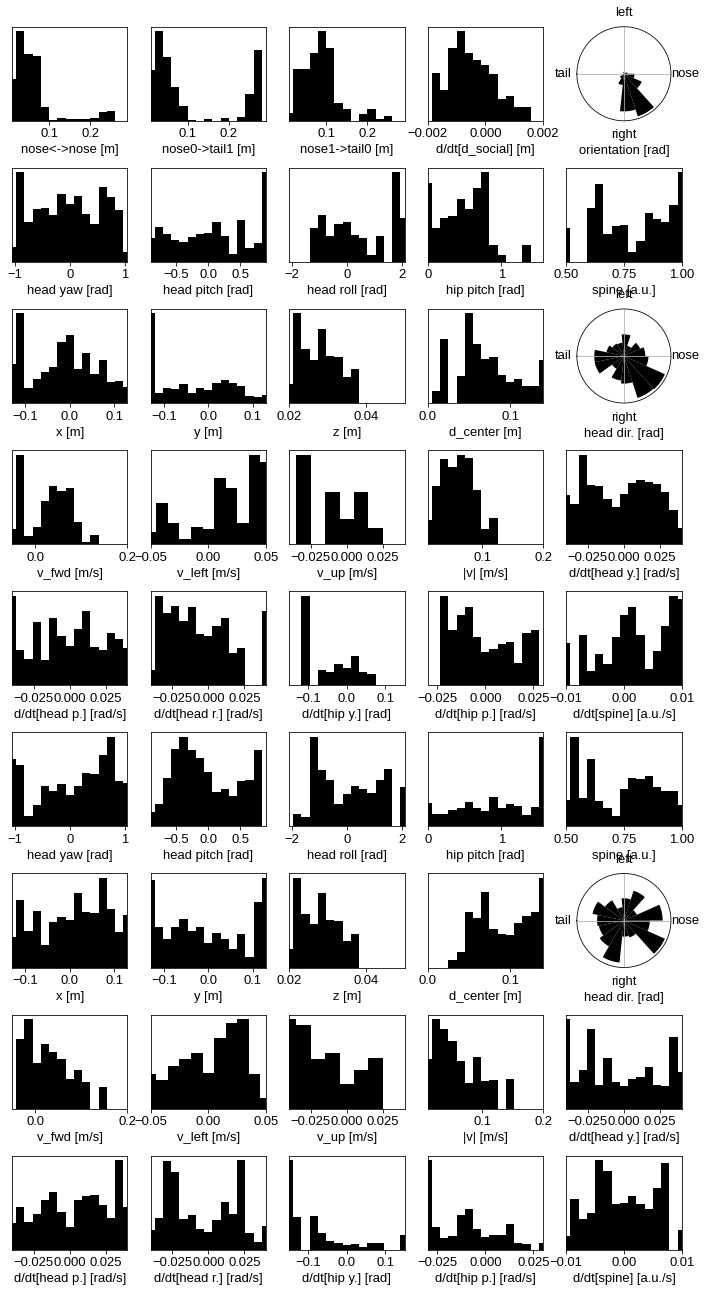

In [34]:
# plot ALL the predictors, that have been included for fitting!

n_p = len(predictor_stack)
sz = 6
plt.figure(figsize = (3*4,2.5*9))
for i_p,p in enumerate(predictor_stack):
    
#     i_sub = np.hstack([np.arange(1,6),np.arange(11,99)])[i_p]
    
    i_sub = 1+i_p
    
    xbins = p['xbins']
    # make firing rate!
    A = p['A']
    A_spikes = np.zeros(A.shape[1])
    for ii in range(A.shape[1]):
        A_spikes[ii] = np.mean(binned_spikes[A[:,ii]])
    A_spikes = A_spikes*fps
    
    
    if p['type'] == '1d':
        ax = plt.subplot(9,5,i_sub)
        ax.bar(xbins,A_spikes,facecolor = 'k',width = np.median(np.diff(xbins)))
        ax.set_xlim(xbins[[0,-1]])
        ax.set_xlabel("{} [{}]".format(p['lab'],p['unit']))
    if p['type'] == '1d_circ':
        ax = plt.subplot(9,5,i_sub,projection='polar')
        ax.bar(xbins,A_spikes,facecolor = 'k',width = np.median(np.diff(xbins)))
        ax.set_xlim([-np.pi,np.pi])
        ax.set_xlabel("{} [{}]".format(p['lab'],p['unit']))
        ax.set_xticks([-np.pi,-np.pi/2,0,np.pi/2])
        ax.set_xticklabels(['tail','right','nose','left'])
    ax.set_yticks([])        
plt.subplots_adjust(hspace=.5)
    


In [35]:


# TODO only need this for the block diagonal, is there a pure numpy/pytorch way?
from scipy.linalg import block_diag
from scipy.optimize import minimize
from utils.glm import neg_ll,jac_ll,hess_ll
from utils.glm import fold_indices,calc_fit_scores,fit_model_spec

def fit_predictor_stack_to_binned_spikes(predictor_stack,binned_spikes):
    # select what kind of model to fit!
    run_start = time.time()

    # start by testing all the 1-predictor models:
    n_predictors = len(predictor_stack)
    model_master = {'model_spec_list': [[i] for i in range(n_predictors)],
                    'model_predictor_list': [1 for i in range(n_predictors)],
                    'model_score_list': [],
                    'model_stack_list': []
                   }

    print('starting to fit 0th level (1 predictor)...')
    for i_model,model_spec in enumerate(model_master['model_spec_list']):
        print('fitting model {} of {} (0th level)...'.format(i_model,len(model_master['model_spec_list'])))

        model_scores, model_stack = fit_model_spec(model_spec,predictor_stack,binned_spikes)
        model_master['model_score_list'].append(model_scores)
        model_master['model_stack_list'].append(model_stack)

    # now do some model selection, first model level:
    # calculate if the model is better than the flat model with a simple mean rate
    mean_llh = [model_scores['test']['mean_log_llh'] for model_scores in model_master['model_score_list'] ]
    pval_baseline = [model_scores['test']['pval_baseline'] for model_scores in model_master['model_score_list'] ]

    # best model:
    best_predictor = np.argmax(mean_llh)
    pval_best_predictor = pval_baseline[best_predictor]

    winning_spec = [ model_master['model_spec_list'][best_predictor] ]
    winning_llh = [ model_master['model_score_list'][best_predictor]['test']['log_llh'] ]
    winning_pval = [pval_best_predictor]
    winning_index = [best_predictor]

    used_predictors = [best_predictor]

    all_predictors = np.arange(n_predictors)
    next_round_predictors = all_predictors[~np.isin(all_predictors,used_predictors)]

    previous_spec = np.array(winning_spec[-1])
    new_model_specs = [np.hstack([previous_spec,ii]) for ii in next_round_predictors]

    # now we loop over the rest of the models!
    for i_level in range(1,n_predictors): # because the first round is a little special due to the mean model
        # now run the fit
        endix = ['th','st','nd','rd','th','th','th','th','th','th']
        print('starting to fit {}{} level ({} predictors)...'.format(i_level,endix[i_level%10],i_level+1))
        for i_model,model_spec in enumerate(new_model_specs):
            print('fitting model {} of {} ({}{} level)...'.format(i_model,len(new_model_specs),i_level,endix[i_level%10]))
            model_scores, model_stack = fit_model_spec(model_spec,predictor_stack,binned_spikes)
            model_master['model_spec_list'].append(model_spec)
            model_master['model_predictor_list'].append(len(model_spec))
            model_master['model_score_list'].append(model_scores)
            model_master['model_stack_list'].append(model_stack)

        # select the best model of the new fits!
        current_level = model_master['model_predictor_list'][-1]
        mean_llh = np.array([model_scores['test']['mean_log_llh'] for model_scores in model_master['model_score_list'] ])
        current_logic = np.isin(model_master['model_predictor_list'] , current_level)
        current_index = np.arange(len(current_logic))[current_logic]
        current_llh = mean_llh[current_logic]

        # some index wrangling
        best_model_index = current_index[np.argmax(current_llh)]
        best_model_scores = model_master['model_score_list'][best_model_index]
        best_model_llh = best_model_scores['test']['log_llh']
        prev_model_llh = winning_llh[-1]

        # test the new best model against the previous best one
        w_candidate,pval_candidate = sp.stats.wilcoxon(best_model_llh,prev_model_llh,alternative='greater')

        if pval_candidate >= 0.05:
            # stop if there is no improvement
            print("Candidate model was not better (p = {}),\nso we're stopping the search!".format(pval_candidate))
            # Let's save it anyway for now, for fun!
            winning_spec.append(model_master['model_spec_list'][best_model_index] )
            winning_llh.append(best_model_llh)
            winning_pval.append(pval_candidate)
            winning_index.append(best_model_index)        
            break

        else:
            # add everything to the growing model tree
            print("Candidate model was better (p = {})!\nWe will grow the tree and keep searching..".format(pval_candidate))

            # add the new best winner to the list
            winning_spec.append(model_master['model_spec_list'][best_model_index] )
            winning_llh.append(best_model_llh)
            winning_pval.append(pval_candidate)
            winning_index.append(best_model_index)

            # get everything ready to do the next round
            all_predictors = np.arange(n_predictors)
            used_predictors = winning_spec[-1]
            next_round_predictors = all_predictors[~np.isin(all_predictors,used_predictors)]

            previous_spec = np.array(winning_spec[-1])
            new_model_specs = [np.hstack([previous_spec,ii]) for ii in next_round_predictors]

    # after fitting, we add the model tree to the dictionary and save it for later    
    run_end = time.time()

    model_master['winning_spec'] = winning_spec
    model_master['winning_llh'] = winning_llh
    model_master['winning_pval'] = winning_pval
    model_master['winning_index'] = winning_index
    model_master['run_time'] =run_end-run_start
    model_master['binned_spikes'] = binned_spikes
    
    return model_master

import pickle
# for i_neuron in [4]:
for i_neuron in range(n_neurons):
#     if dict is already done, don't do it again...
    
    cluster_id = cluster_info.id.values[i_neuron]

    pickle_name = "model_masters/45pred_i_neuron_{}.p".format(i_neuron)

    if os.path.exists(pickle_name):
        continue

   
    spike_times = spike_index_phy[clusters_phy == cluster_id]/sample_rate + ephys_rec_start_time

    # we do a little trick here, due to how np.hist handles edges
    bin_edges = np.hstack([behavior_stamps,behavior_stamps[-1]+np.median(np.diff(behavior_stamps))])
    binned_spikes,_ = np.histogram(spike_times,bins = bin_edges)

    # there will be a gigantic count in the break in the recording, which we will simply kill off!
    # TODO handle this better, goog enough for now
    binned_spikes[np.diff(bin_edges)> 10*np.median(np.diff(bin_edges))] = 0
    # convert from spike count to rate!
    binned_rate = binned_spikes/np.median(np.diff(behavior_stamps))

    
    model_master = fit_predictor_stack_to_binned_spikes(predictor_stack,binned_spikes)
    
    # dump the saved dicts
    pickle.dump(model_master, open(pickle_name, "wb"))  # save it into a file named save.p


[0]
[0 2]


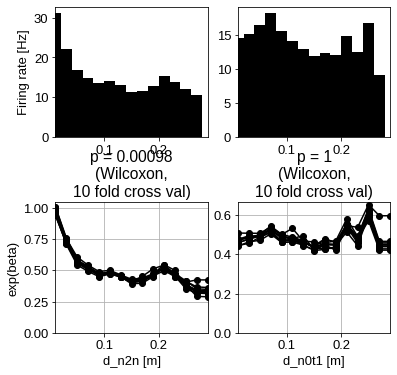

[2]
[2 0]
[2 0 1]


/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


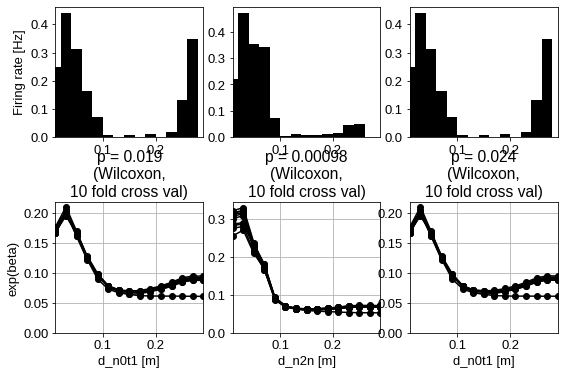

[0]
[0 1]


/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


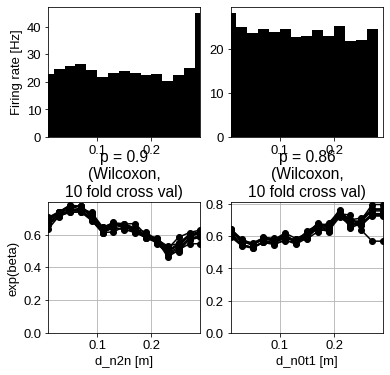

[0]
[0 2]


/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


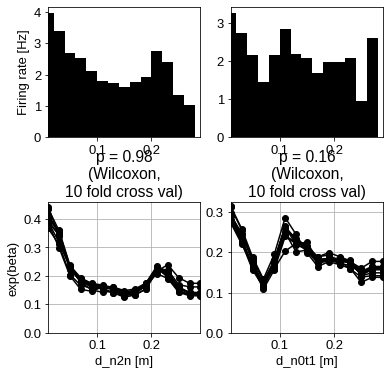

[0]
[0 1]


/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


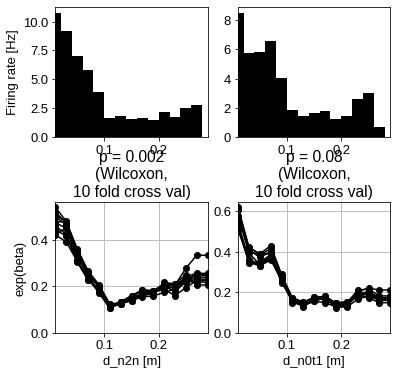

[0]
[0 2]


/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


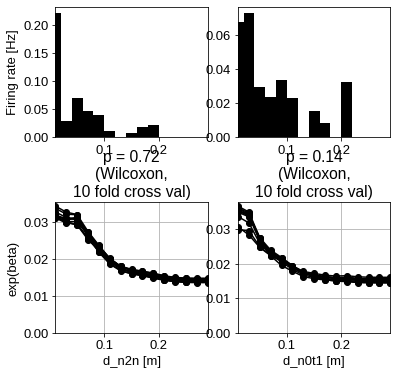

[0]
[0 1]


/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


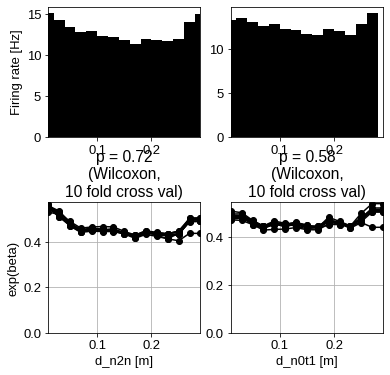

[2]
[2 1]


/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


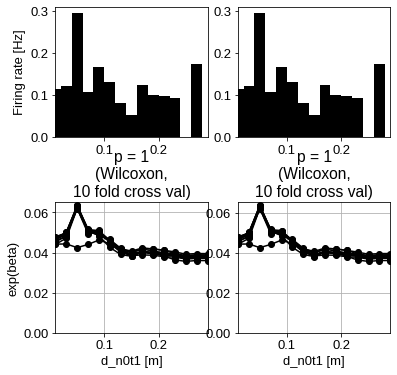

[0]
[0 1]


/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


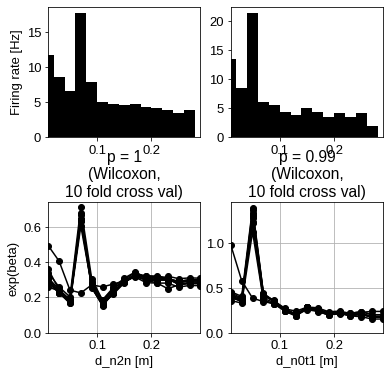

[0]
[0 1]


/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


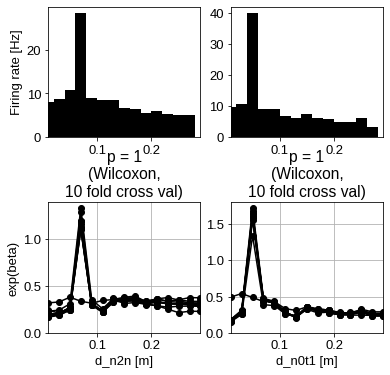

[0]
[0 1]


/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


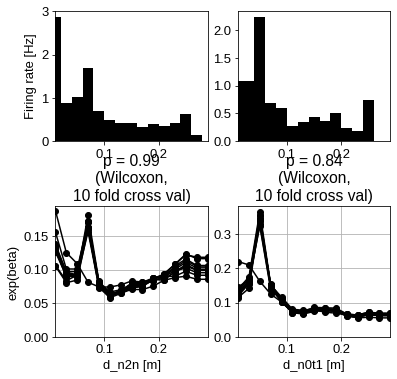

[0]
[0 1]


/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


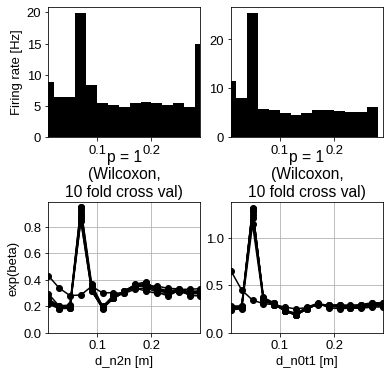

[0]
[0 1]


/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


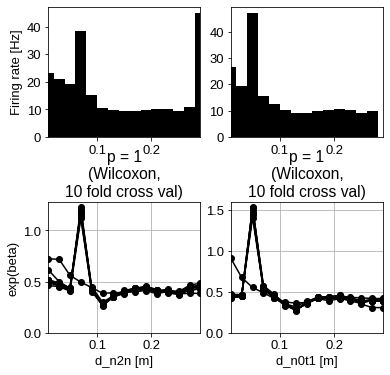

[0]
[0 1]


/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


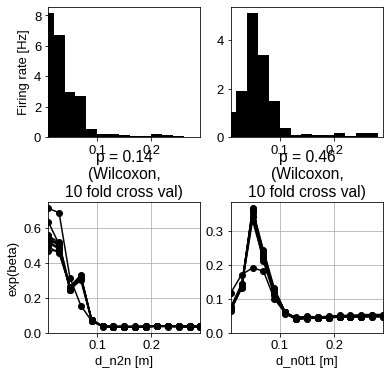

[0]
[0 1]


/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


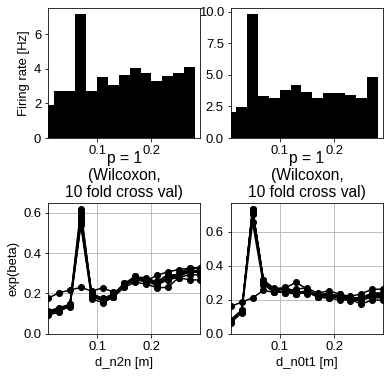

[0]
[0 1]


/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


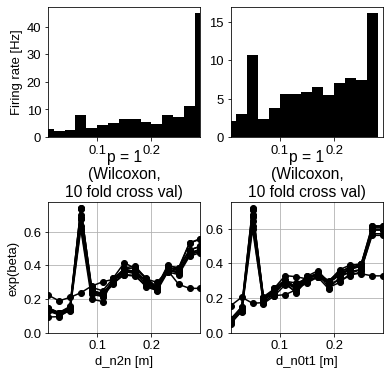

[0]
[0 1]


/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


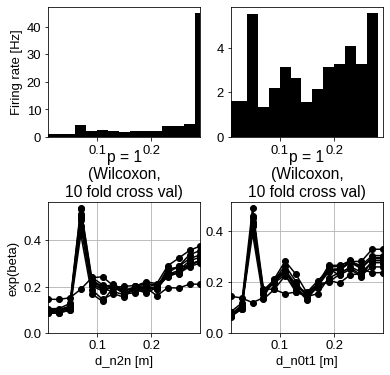

[0]
[0 1]


/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


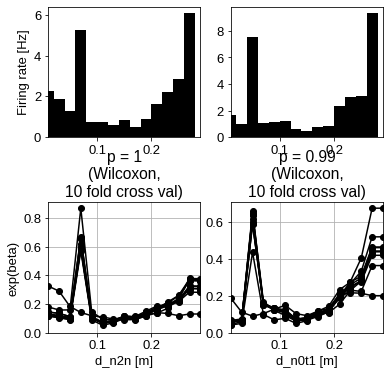

[0]
[0 1]


/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


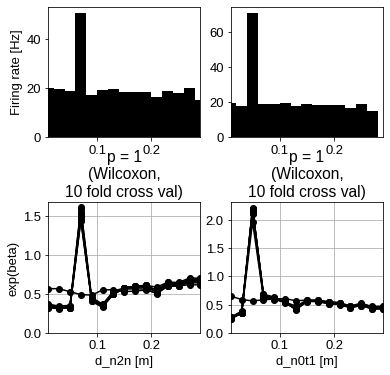

[0]
[0 1]


/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


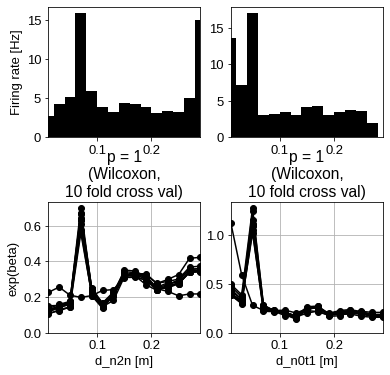

[0]
[0 1]


/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


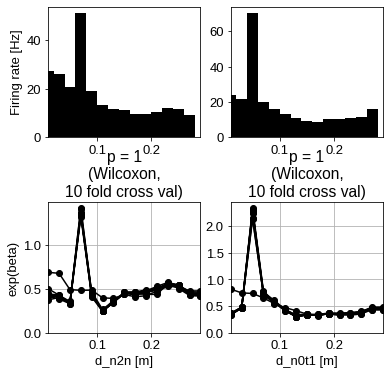

[0]
[0 1]


/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


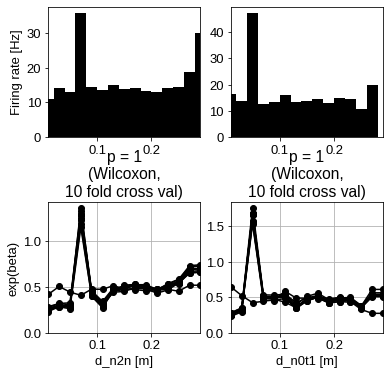

[0]
[0 1]


/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


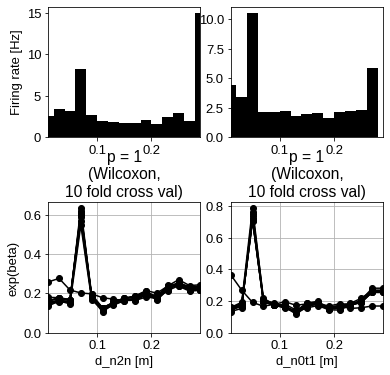

[0]
[0 1]


/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


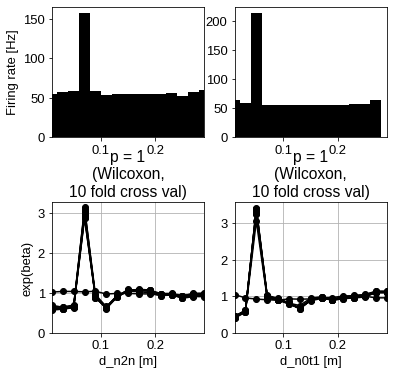

[0]
[0 1]


/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


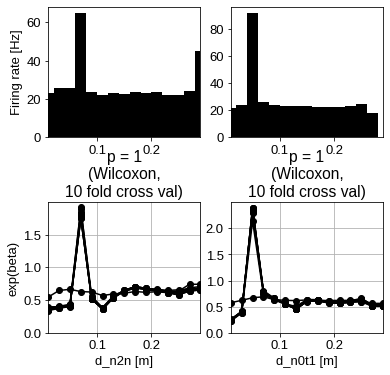

[0]
[0 1]


/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


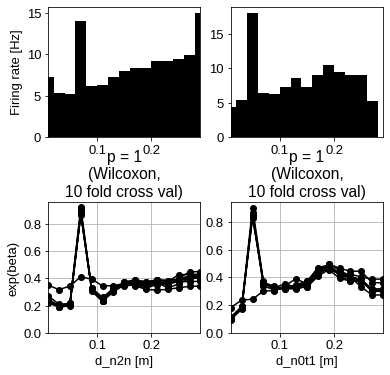

[0]
[0 1]


/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


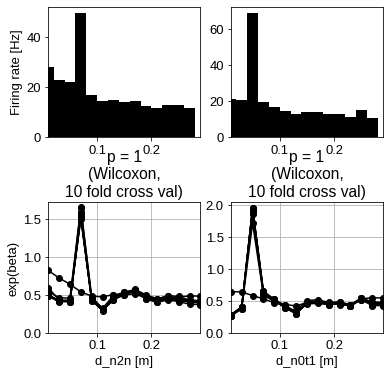

[0]
[0 1]


/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


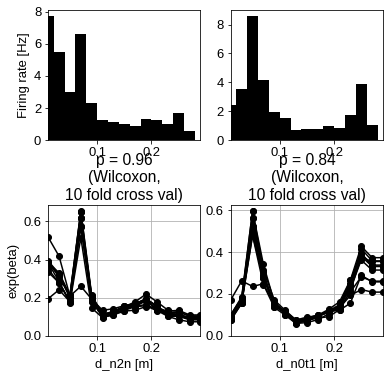

[0]
[0 1]


/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


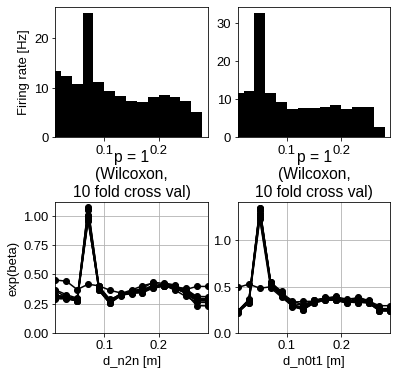

[1]
[1 2]


/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


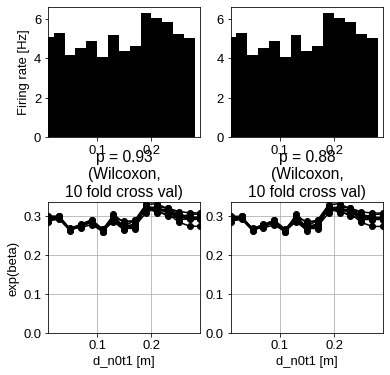

[1]
[1 0]


/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


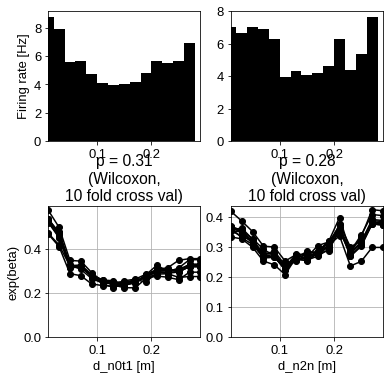

In [428]:
def plot_winning_model(model_master,predictor_stack):
    # after fitting, we save the winning models
    winning_spec = model_master['winning_spec']
    winning_llh = model_master['winning_llh'] 
    winning_pval = model_master['winning_pval']
    winning_index =model_master['winning_index'] 
    binned_spikes = model_master['binned_spikes']


    # also get the names!

    model_master['winning_names']  = []
    for spec in winning_spec:
        print(spec)
        p_names = []
        for ii in spec:
            p_names.append(predictor_stack[ii]['name'])
        model_master['winning_names'].append(p_names)

    # AND we calculate all the tuning curves (marginalizing out the effect of the others)
    # 1D tuning curves!

    model_master['winning_curves']  = []
    model_master['winning_xbins']  = []
    model_master['winning_A_spikes'] = []
    model_master['winning_units']  = []

    spec = winning_spec[-1]
    model = model_master['model_score_list'][winning_index[-1]]
    winning_curves = np.vstack(model['param_holder'])
    tuning = np.mean(winning_curves,axis = 0)
    nsub_running = 0
    for i_predic in spec:
        p = predictor_stack[i_predic]
        xbins = p['xbins']

        nsub = p['nsub']
        sub_index = np.arange(nsub)+nsub_running

        nsub_running += nsub

        model_master['winning_curves'].append(winning_curves[:,sub_index])
        model_master['winning_xbins'].append(xbins)


        # also add the 'RAW' counts
        # get the A_matrix (that's the binning)
        A = p['A']
        # now, use that binning to segment the firing rate
        A_spikes = np.zeros(A.shape[1])
        for ii in range(A.shape[1]):
            A_spikes[ii] = np.mean(binned_spikes[A[:,ii]])

        model_master['winning_A_spikes'].append(A_spikes)


    n_win = len(winning_spec[-1])
    plt.figure(figsize=(3*n_win,3*2))
    for i in range(n_win):
        xbins,curves = model_master['winning_xbins'][i],model_master['winning_curves'][i]
        A_spikes = model_master['winning_A_spikes'][i]

        # make firing rate!
        A_spikes = A_spikes * fps

        plt.subplot(2,n_win,1+i)
        plt.bar(xbins,A_spikes,facecolor = 'k',width = np.median(np.diff(xbins)))
        plt.xlim(xbins[[0,-1]])
        if i == 0:
            plt.ylabel('Firing rate [Hz]')

    #     plt.ylim([0,1])

        plt.subplot(2,n_win,n_win+1+i)
        for ii in range(curves.shape[0]):
            plt.plot(xbins,np.exp(curves[ii,:]),'o-k')


        name = model_master['winning_names'][-1][i]

        for p in predictor_stack: # TODO not so nice
            if p['name'] == name:
                unit = p['unit']

        name = model_master['winning_names'][-1][i]
        plt.xlabel("{} [{}]".format(name,unit))
    #     plt.xticks(xbins)
        plt.ylim([0,None])
        plt.xlim(xbins[[0,-1]])
#         plt.ylim([0,1.2])
        plt.grid()
        if i == 0:
            plt.ylabel('exp(beta)')
        plt.title("p = {:0.2g}\n(Wilcoxon,\n10 fold cross val)".format(winning_pval[i]))

        # make a common x-axis?
        plt.subplots_adjust(hspace=.5)

    plt.show()

    
for i_neuron in range(n_neurons):
#     if dict is already done, don't do it again...
    
    cluster_id = cluster_info.id.values[i_neuron]
    
    model_master = pickle.load(open("model_masters/45pred_i_neuron_{}.p".format(i_neuron), "rb"))  # save it into a file named save.p

    plot_winning_model(model_master,predictor_stack)    

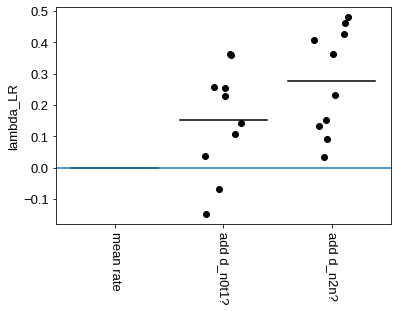

In [399]:
# also plot the progress over time of the log ll

def plot_ll_increase(model_master,predictor_stack):

    plt.figure()
    winning_llh = model_master['winning_llh'] 

    winning_score = []

    for i_ll,ll in enumerate(winning_llh):
        jitter = .1*np.random.normal(size = len(ll))
        plt.plot(1+i_ll*np.ones_like(ll)+jitter,ll,'ok')
        plt.plot(1+i_ll+np.array([-.4,.4]),np.ones(2)*np.mean(ll),'-k')

    plt.plot(np.array([-.4,.4]),np.zeros(2),'-k')

    ax = plt.gca()
    ax.set_ylabel('lambda_LR')
    labels = ['mean rate']
    for name in model_master['winning_names'][-1]:
        labels.append("add {}?".format(name))

    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels,rotation = -90)

    # plot the p-values

    # for p in 

    plt.axhline(0)
    plt.show()

plot_ll_increase(model_master,predictor_stack)





In [335]:
for model_spec in new_model_specs:
    model_scores, model_stack = fit_model_spec(model_spec,predictor_stack,binned_spikes)
    model_master['model_spec_list'].append(model_spec)
    model_master['model_predictor_list'].append(len(model_spec))
    model_master['model_score_list'].append(model_scores)
    model_master['model_stack_list'].append(model_stack)


    

fitting fold #0...
fitting fold #1...
fitting fold #2...
fitting fold #3...
fitting fold #4...
fitting fold #5...
fitting fold #6...
fitting fold #7...
fitting fold #8...
fitting fold #9...
